# Model to predict items for one unique customer id
This notebook encloses the creation of new tables for one randomly selected user, followed by feature engineering (each one explained in the code chuncks), fine tuning the model and running a logistic regression to predict the items that will be in the cart using "prior" data to train the model and "train" to test it.

For the model I am only considering the reorder prediction (based on the products the user have previously bought at least once). It is not accounting for new products.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#1 Loading the data (different tables)

In [2]:
aisles = pd.read_csv('./datasets/aisles.csv')
order_prior = pd.read_csv('./datasets/order_products__prior.csv')
order_train = pd.read_csv('./datasets/order_products__train.csv')
orders = pd.read_csv('./datasets/orders.csv')
prod1 = pd.read_csv('./datasets/products.csv')
dept = pd.read_csv('./datasets/departments.csv')

#2 Subsetting the data and merging orders / order_prior / order_train tables as explained in the Data analysis part. Again, eval_set = prior is going to be used for train and eval_set = train for test

In [3]:
orders.shape

(3421083, 7)

In [4]:
train = orders[orders['eval_set'] == 'prior']
test = orders[orders['eval_set'] == 'train']
final = orders[orders['eval_set'] == 'test']
train = train.merge(order_prior[['add_to_cart_order', 'reordered', 'product_id' ,'order_id']],\
                                left_on = 'order_id', right_on = 'order_id', how = 'inner')
test = test.merge(order_train[['add_to_cart_order', 'reordered', 'product_id','order_id']],\
                                left_on = 'order_id', right_on = 'order_id', how = 'inner')


#3 Creating one big table with train and test data merged data. This big table will be the input for the for loop below that will iterate over each user_id, create a customized table based on feature engineering, run the model and store the results in a list. This list will be extended to all user_id's results so that we can calculate the model accuracy based on this 500 users.

In [5]:
total = pd.concat([train, test], axis=0)
total = total.drop('eval_set',1)

#4 Creating a new table per user_id to be used in the model

In [64]:
#randomly selecting the user_id
import random
foo = total['user_id']
n = random.choice(foo)

# Code chunck to recreate table based on user id to be used to build and run the model.


In [65]:
usern = total[total['user_id']==n] #Change n to the user_id you got from the random result
products = usern['product_id'].unique() #list of unique products bought by the id
orders_id = usern['order_id'].unique() #list of unique orders id bought by the id

#creating a list of lists that contains the unique products for the total number of orders
#a has lenght of products times number of unique orders.
#list_2 has unique products times number of orders
a = np.tile(products,(len(orders_id),1))
list_1 = [i for sublist in a for i in sublist]
list_2 = [[i] * len(products) for i in orders_id]
list_2 = [i for sublist in list_2 for i in sublist]

#creating a list with the same user id * lenght of list_2 to create the user column in the final
#dataframe to be used in the model.
user_id = []
for i in list_2:
    user_id.append(n) 
    
#Creating the first columns of the final table: order id, user id and product id.
userntrain = pd.DataFrame(np.column_stack([list_2, user_id, list_1]), 
                               columns=['order_id', 'user_id', 'product_id'])

#Creating reordered column for the data frame: if product has been reordered at least once 
#it is assigned as 1, else = 0. (Remember we have all products once bought for all orders_id 
#in this version of data frame, despite the fact they were part of one specific order).
userntrain = userntrain.sort_values(['order_id', 'product_id'])
userntrain['reordered'] = [i == 0. for i in range(len(userntrain['user_id']))]

#Creating order number column by getting unique order numbers based on usern table and merging 
#with the new table we are creating so we will have the order number repeated by all products
number = usern.groupby('order_id')['order_number'].unique().reset_index()
number['order_number'] = [i for sublist in number['order_number'] for i in sublist]
userntrain = userntrain.merge(number, on='order_id', how='left').sort_values('order_number')

#Same we did with to have the column that says if the product was added to the cart
#in that specific order. 0 = yes and 1 = no.
reor = usern.groupby(['order_id', 'product_id'])['reordered'].sum().reset_index()
reor['to_cart'] = [i == 'True' for i in range(len(reor['order_id']))]

#merging these new columns with the dataset we are creating
temp2 = userntrain
temp2 = temp2.merge(reor, how='left', on=['order_id', 'product_id'])
temp2.drop('reordered_x', 1, inplace=True)
temp2['to_cart'].fillna(True, inplace=True)

#Reversing to cart to be 1 = yes and 0 = no.
cart = []
for i in temp2['to_cart']:
    if i == True:
        cart.append(False)
    else:
        cart.append(True)
        
temp2['to_cart'] = cart
temp2['to_cart'].fillna(True, inplace=True)

#Same as above for reordered column.
r = []
for i in temp2['reordered_y']:
    if i == 1:
        r.append(True)
    else:
        r.append(False)
        
temp2['reordered_y'] = r

#Creating column that counts days since previous order 
daysince = usern.groupby(['order_id', 'days_since_prior_order'])['reordered'].sum().reset_index()
daysince.drop('reordered', 1, inplace=True)


#Creating day of the week order was placed 
doweek = usern.groupby(['order_id', 'order_dow'])['reordered'].sum().reset_index()
doweek.drop('reordered', 1, inplace=True)

#Creating hour of day order was placed 
hod = usern.groupby(['order_id', 'order_hour_of_day'])['reordered'].sum().reset_index()
hod.drop('reordered', 1, inplace=True)


#adding days since previous, day of week and hour of day to the dataset.
temp3 = temp2
temp3 = temp3.merge(daysince, how='left', on='order_id')
temp3 = temp3.merge(doweek, how='left', on='order_id')
temp3 = temp3.merge(hod, how='left', on='order_id')
temp3.fillna(999, inplace=True)
#Changing boolean to integer
temp3['reordered_y'] = temp3['reordered_y']*1
temp3['to_cart'] = temp3['to_cart']*1

#printing the user we are working with
print n

156091


#5. Modeling

In [66]:
#Getting baseline
baseline_counts = temp2['to_cart'].value_counts().max()/float(len(temp3['to_cart']))
print "baseline acc: ", baseline_counts

baseline acc:  0.865196078431


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.4s finished


0.891503267974
{'penalty': 'l1', 'C': 0.097700995729922469, 'solver': 'liblinear'}
TP =  11
FP =  0
TN =  37
FN =  3
             precision    recall  f1-score   support

          0       0.93      1.00      0.96        37
          1       1.00      0.79      0.88        14

avg / total       0.95      0.94      0.94        51



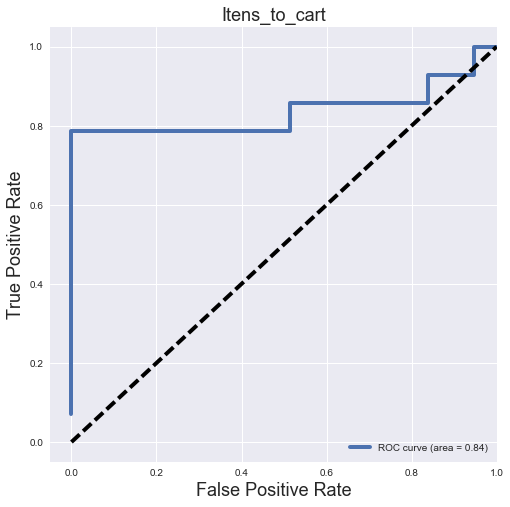

In [67]:
#Preparing to run Logistic Regression:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
import numpy as np

#Train / test selection based on table for the unique id.
train = temp3[temp3['order_number']!=len(orders_id)] 
test = temp3[temp3['order_number']==len(orders_id)] 

#Defining targets and features for train and test
y_train = train['to_cart']
X_train = train.drop(['to_cart', 'order_id'], 1)
y_test = test['to_cart']
X_test = test.drop(['to_cart', 'order_id'], 1)

#Gridsearching for best parameters
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)

lr_gridsearch.fit(X_train, y_train)



# best score on the training data:
print lr_gridsearch.best_score_

print lr_gridsearch.best_params_

#Running model and making predictions based on best parameters.
best_lr = lr_gridsearch.best_estimator_

best_lr.fit(X_train, y_train)

best_lr.score(X_train, y_train)

ypred = best_lr.predict(X_test)
yproba = best_lr.predict_proba(X_test)

tp = np.sum((y_test == 1) & (ypred == 1))
fp = np.sum((y_test == 0) & (ypred == 1))
tn = np.sum((y_test == 0) & (ypred == 0))
fn = np.sum((y_test == 1) & (ypred == 0))
print "TP = " , tp
print "FP = " , fp 
print "TN = " , tn 
print "FN = " , fn


from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, ypred)

print classification_report(y_test, ypred)


#plotting ROC
Y_pp = pd.DataFrame(best_lr.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
Y_pp.head()

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Itens_to_cart', fontsize=18)
plt.legend(loc="lower right")
plt.show()



In [68]:
best_lr.coef_ = np.ravel(best_lr.coef_)
best_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':best_lr.coef_, 'abs_coef':np.abs(best_lr.coef_)})

best_coefs.sort_values('abs_coef', inplace=True, ascending=False)

best_coefs

,abs_coef,coef,variable
3,3.681102,3.681102,reordered_y
2,0.099549,0.099549,order_number
5,0.063152,0.063152,order_dow
6,0.012164,0.012164,order_hour_of_day
4,0.001426,0.001426,days_since_prior_order
0,0.000025,-0.000025,user_id
1,0.000006,0.000006,product_id


In [69]:
conmat = np.array(confusion_matrix(y_test, ypred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['added to cart', 'not added to cart'],
                         columns=['Predicted added','Predicted not added'])
confusion

,Predicted added,Predicted not added
added to cart,11,3
not added to cart,0,37


In [70]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_f.fit(X_train, y_train)
skb_chi2.fit(X_train, y_train)

# examine results
cols = X_train.columns
kbest = pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest

,feature,f_classif,chi2 score
3,reordered_y,667.251,334.5
2,order_number,14.5939,33.5009
6,order_hour_of_day,4.29347,2.0985
5,order_dow,3.10193,4.95595
1,product_id,1.73204,19763.2
4,days_since_prior_order,0.668135,521.066
0,user_id,NaN,0


# Building Ensemble Models to check if they perform better

In [71]:
#Trying Decision Trees, Random Forest and Gradient Boosting to compare model results
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [72]:
rf = RandomForestClassifier()
cross_val_score(rf, X_train, y_train, cv=cv).mean()

0.90065359477124185

In [73]:
grad = GradientBoostingClassifier()
cross_val_score(grad, X_train, y_train, cv=cv).mean()

0.92679738562091496

In [74]:
rf_params = {'n_estimators':[10, 25, 50], 'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}

In [75]:
grid_rf = GridSearchCV(rf, param_grid=rf_params, verbose=1, cv=cv)
grid_rf.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   18.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50], 'min_samples_split': [2, 5, 10], 'max_depth': [3, 5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [76]:
grid_rf.best_score_

0.93725490196078431

In [77]:
grad_params = {"max_depth" : [3, 5, 10, 25, None],
              'min_samples_split': [2, 5, 10],
              "n_estimators": [10, 25, 50], 'learning_rate':[0.5, 1]
             }

In [78]:
grad = GradientBoostingClassifier()

grid_grad = GridSearchCV(grad, param_grid=grad_params, verbose=1, cv=cv)
grid_grad.fit(X_train,y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   14.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10], 'n_estimators': [10, 25, 50], 'learning_rate': [0.5, 1], 'max_depth': [3, 5, 10, 25, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [79]:
grid_grad.best_score_


0.92679738562091507

In [80]:
grid_grad.best_params_

{'learning_rate': 0.5,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 10}

In [81]:
grad_best = grid_grad.best_estimator_
grad_best.fit(X_train, y_train)

grad_best.score(X_train, y_train)

ypred = grad_best.predict(X_test)
yproba = grad_best.predict_proba(X_test)

tp = np.sum((y_test == 1) & (ypred == 1))
fp = np.sum((y_test == 0) & (ypred == 1))
tn = np.sum((y_test == 0) & (ypred == 0))
fn = np.sum((y_test == 1) & (ypred == 0))
print "TP = " , tp
print "FP = " , fp 
print "TN = " , tn 
print "FN = " , fn

TP =  11
FP =  1
TN =  36
FN =  3


## Based on results I will stick to logistic regression to build the model that accepts multiple Ids and average the results.